In [1]:
import pickle as pkl
from QAOAUtils import *
from tqdm import tqdm
from tqdm.contrib import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import pandas as pd

In [2]:
Random_QUBO_DATA= pkl.load( open ("RandomQUBODepth0Test.p", "rb") )
TSP_MIS_DATA= pkl.load( open ("TSPMISDepth0Test.p", "rb") )
PO_DATA= pkl.load( open ("PortfolioOptDepth0Test.p", "rb") )

In [3]:
p_data = {'Continous':Random_QUBO_DATA[0:4],'Discrete':Random_QUBO_DATA[4:8]} | {'TSP':TSP_MIS_DATA[0:4]} | {'Portfolio Optimization':PO_DATA[0:4]} | {'MIS-GNP':TSP_MIS_DATA[4:8],'MIS-NWS':TSP_MIS_DATA[8:12]}
A_list = {prob:p_data[prob][-1] for prob in p_data.keys()}


In [4]:
m_list = {k:[] for k in p_data.keys()}
for prob in p_data.keys():
    for A in tqdm(p_data[prob][-1]):
        m_list[prob].append(-brute_force_maxcut(-A)[-1] )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
def plot(prob):
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(4, 8, wspace=1.5, hspace=.75)
    plt.suptitle(prob+' data')
    output = {'cost':{},'probs':{}}
    
    comparison_data,best_angle_data,ws_data = p_data[prob][:-1]
    n=p_data[prob][3][0].shape[0]

    order = [[0, slice(0, 4)],[1, slice(0, 4)], [2, slice(0, 4)], [3, slice(0, 4)]]
    for i,ws in enumerate(['BM2','BM3','GW2','GW3']):
        ax = fig.add_subplot(gs[order[i][0], order[i][1]])
        output['cost'][ws] = np.array(ax.hist(reduce(lambda x,y:x+y,best_angle_data[ws]['max_cost']),bins=range(0,n+2))[0],dtype='int')
        ax.set_title(ws)
        ax.set_ylabel('Count')
        ax.set_xlabel('Vertex Rotation')
        ax.get_xaxis().set_ticks(np.array(range(n+1))+.5)
        ax.set_xticklabels([str(i) for i in range(n)]+["None"])
    
    order = [[0, slice(4, 8)],[1, slice(4, 8)], [2, slice(4, 8)], [3, slice(4, 8)]]
    for i,ws in enumerate(['BM2','BM3','GW2','GW3']):
        ax = fig.add_subplot(gs[order[i][0], order[i][1]])
        output['probs'][ws] = np.array(ax.hist(reduce(lambda x,y:x+y,best_angle_data[ws]['max_probs']),bins=range(0,n+2))[0],dtype='int')
        ax.set_title(ws)
        ax.set_ylabel('Count')
        ax.set_xlabel('Vertex Rotation')
        ax.get_xaxis().set_ticks(np.array(range(n+1))+.5)
        ax.set_xticklabels([str(i) for i in range(n)]+["None"])
    plt.show()
    return output 

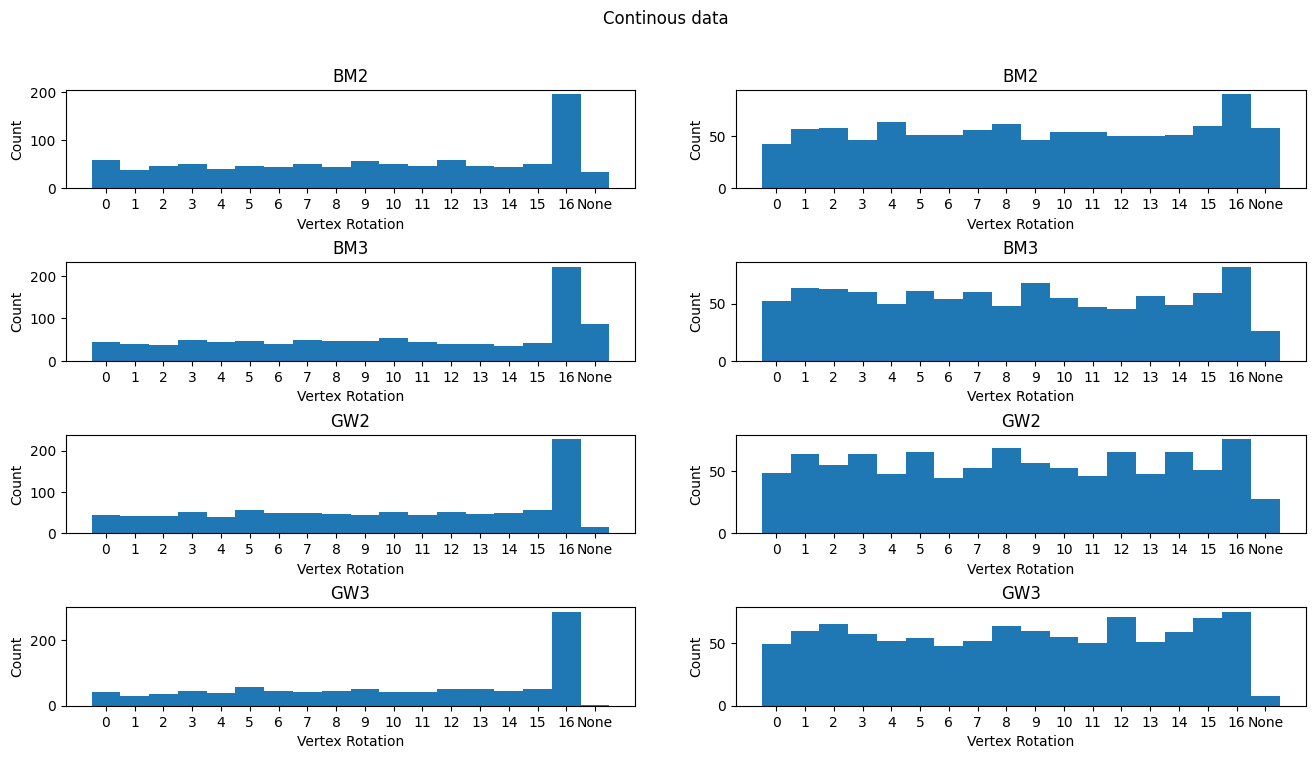

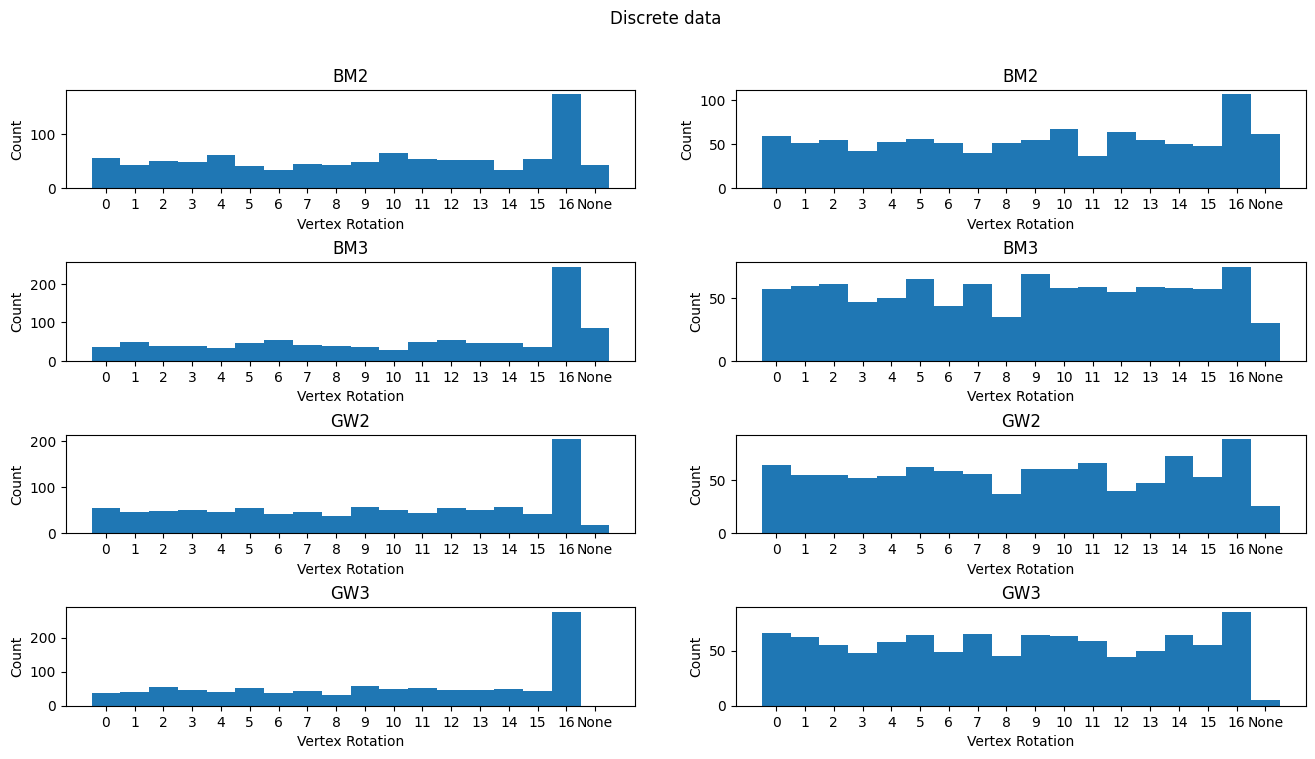

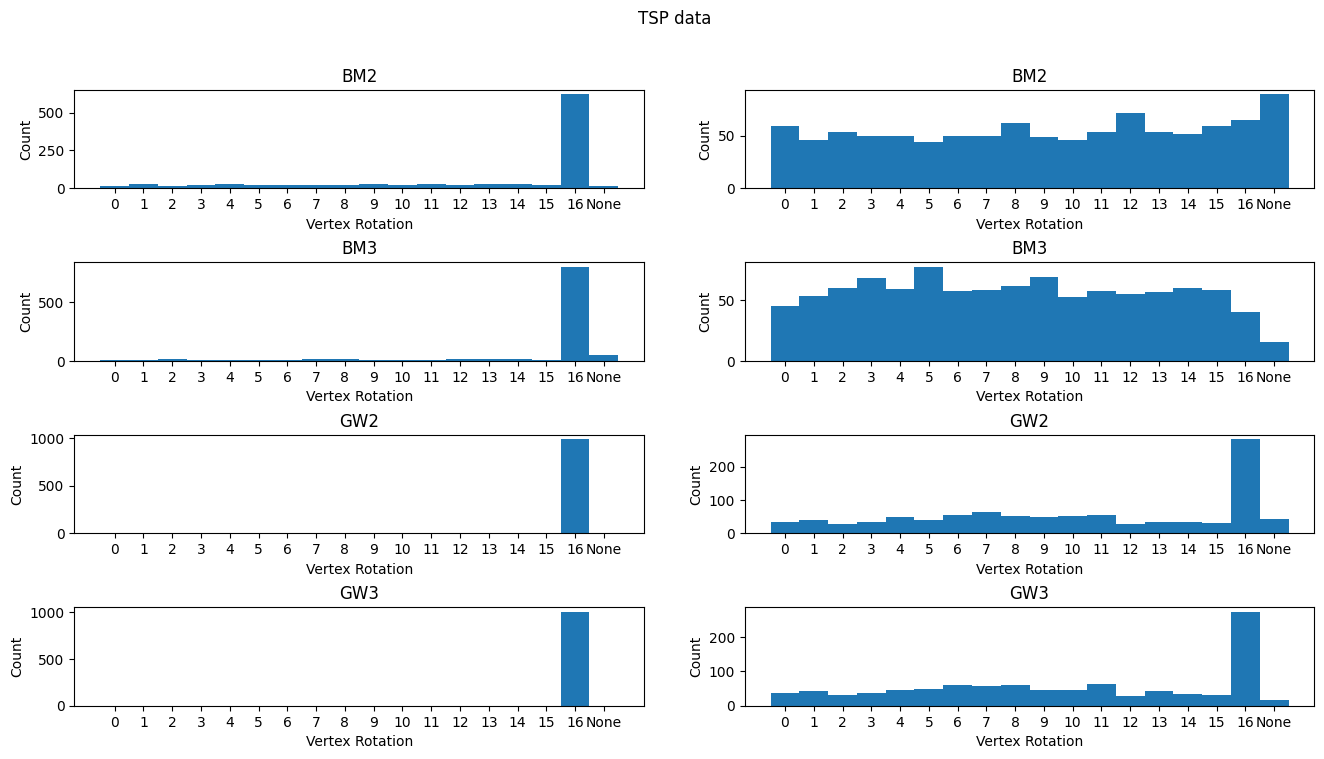

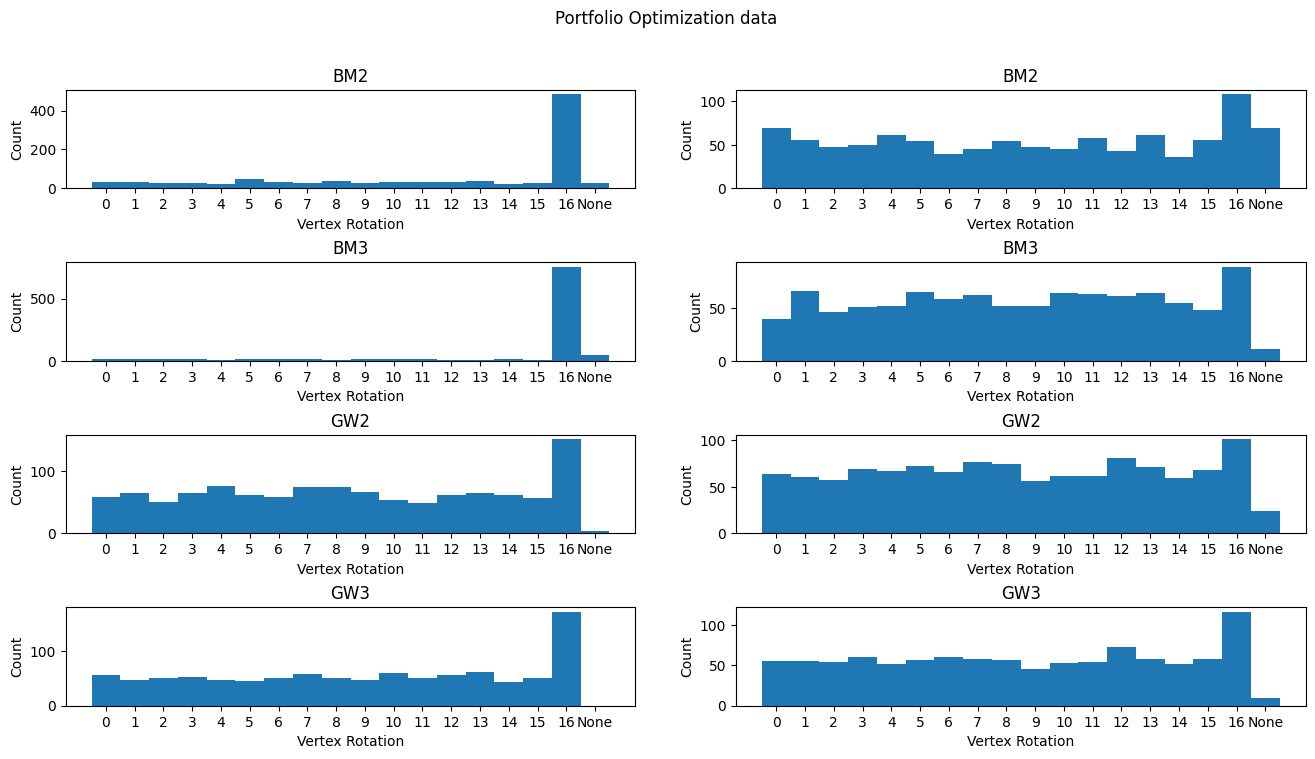

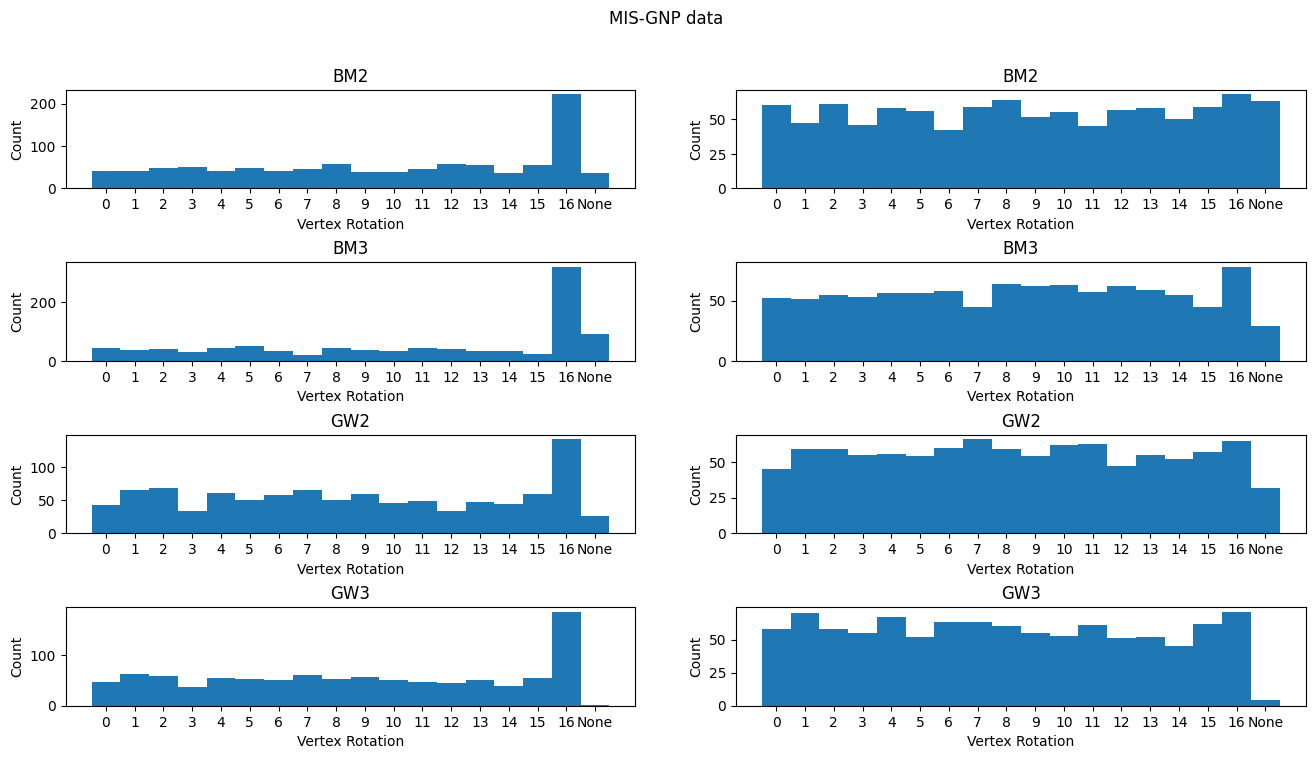

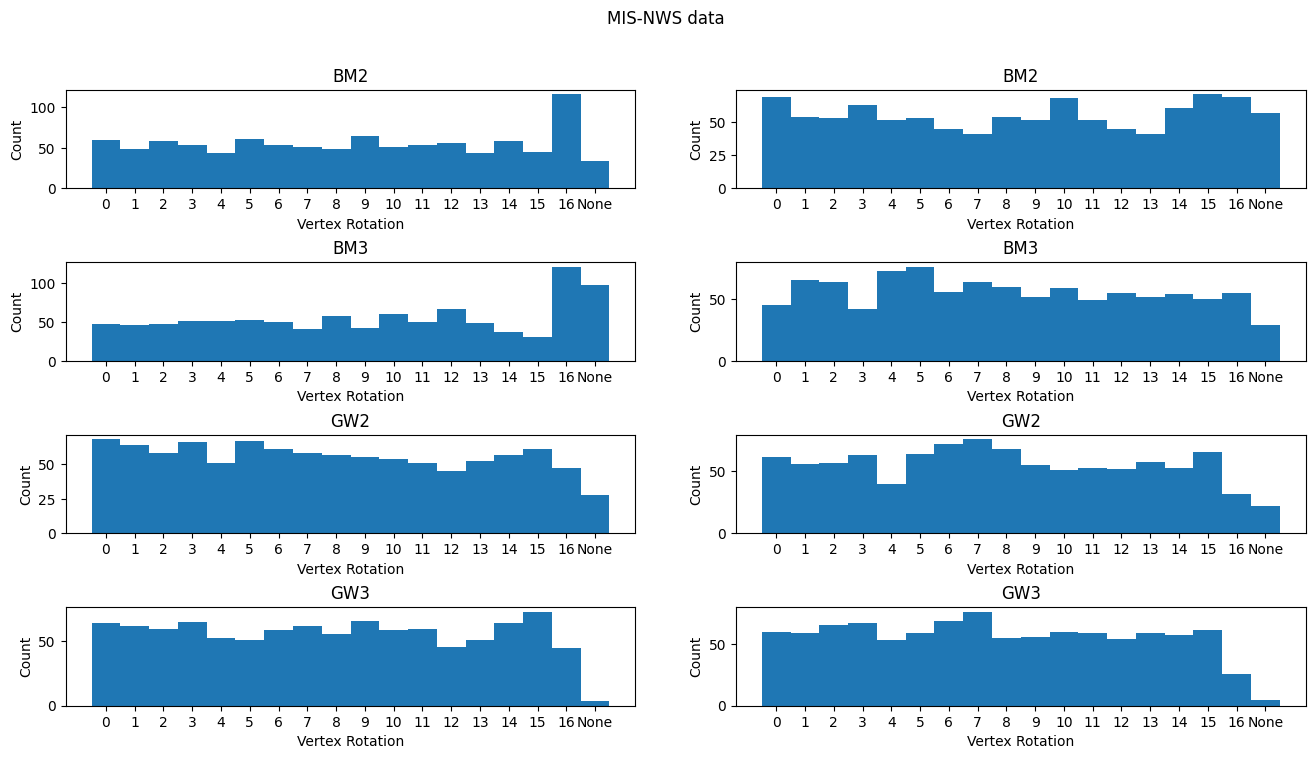

In [6]:
best_angle_data = {prob:plot(prob) for prob in p_data.keys()}

In [7]:
prob_tex = {'BM2':'$\\textrm{BM}_2$','BM3':'$\\textrm{BM}_3$','GW2':'$\\textrm{GW}_2$','GW3':'$\\textrm{GW}_3$'}
def get_latex_hist(prob):
    cost_df=pd.DataFrame.from_dict(best_angle_data[prob]['cost'],orient='index',columns=np.array([str(i) for i in range(17)]+["None"]))
    cost_df_s = cost_df.style.format()
    for row in cost_df.index:
        if(cost_df.loc[row].max()>cost_df.loc[row].mean()+2*cost_df.loc[row].std()):
            col = cost_df.loc[row].idxmax()
            cost_df_s = cost_df_s.format(lambda x: "\\color{red}{\\textbf{" + f'{x}' + "}}", subset=(row,col))
    
    probs_df=pd.DataFrame.from_dict(best_angle_data[prob]['probs'],orient='index',columns=np.array([str(i) for i in range(17)]+["None"]))
    probs_df_s = probs_df.style.format()
    for row in probs_df.index:
        if(probs_df.loc[row].max()>probs_df.loc[row].mean()+2*probs_df.loc[row].std()):
            col = probs_df.loc[row].idxmax()
            probs_df_s = probs_df_s.format(lambda x: "\\color{blue}{\\textbf{" + f'{x}' + "}}", subset=(row,col))
    if(prob == 'Continous'):
        output = '\\begin{center}\n\\captionof*{table}{\\fontsize{8pt}{8pt}\\selectfont '+prob+'}'+'\n\\vspace{-0.3cm}\n'+'\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{|l||*{18}{c|}}\\hline \n \\backslashbox{$\\alpha$}{$\\mathcal{P}$}'+reduce(lambda x,y:x+y,["&"+str(i) for i in range(17)]+["&None"])+'\n\\\\\\hline\\hline'
    else:
        output = '\\begin{center}\n\\captionof*{table}{\\fontsize{8pt}{8pt}\\selectfont '+prob+'}\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{|l||*{18}{c|}}\\hline \n \\backslashbox{$\\alpha$}{$\\mathcal{P}$}'+reduce(lambda x,y:x+y,["&"+str(i) for i in range(17)]+["&None"])+'\n\\\\\\hline\\hline'
    for j,ws in enumerate(['BM2','BM3','GW2','GW3']):
        row = "\n"+prob_tex[ws]+" & "
        for i in range(18):
            cost = [x.split("&")[1:] for x in cost_df_s.to_latex().split("\n")[2:-2]][j][i]
            probs = [x.split("&")[1:] for x in probs_df_s.to_latex().split("\n")[2:-2]][j][i]
            if(i == 17):
                row+=("\\backslashbox{"+cost[:-2]+"}{"+probs[:-2]+"}\\\\\\hline")
            else:
                row+=("\\backslashbox{"+cost+"}{"+probs+"}&")
        row+=" "
        output+=row
    output+='\n'+'\\end{tabular}}\n\\end{center}\n'
    return(output)

In [8]:
f = open(r'Figures\hist_data.tex','w')
print("\\begin{figure*}\n", file=f )
for prob in p_data.keys():
    print(get_latex_hist(prob), file=f)
print("\\caption{Each cell contains how often each vertex-at-top rotation choice maximizes $\\alpha$ and $\\mathcal{P}$ for each warmstart. Problem Dataset is the $1000$ problem instances for each problem type (see Section~\\ref{setup}). Outliers for $\\alpha$ ($\\mathcal{P}$) are values which are $2$ standard deviations above the mean, and are indicated with {\\color{red}\\textbf{red}} ({\\color{blue}\\textbf{blue}})}", file=f)
print("\\label{HistData}", file=f)
print("\\end{figure*}", file=f)
f.close()


In [9]:
def get_mean_stds(prob):
    output = {}
    for w in (['BM2','BM3','GW2','GW3']):
        comparison_data, best_angle_data, ws_data = p_data[prob][:-1]
        m = np.array(m_list[prob])
        M = np.array([d[-1] for d in ws_data])

        first_alpha = (np.array(comparison_data[w][0]['cost'])-m)/(M-m)
        none_alpha = (np.array(comparison_data[w][None]['cost'])-m)/(M-m)
        last_alpha = (np.array(comparison_data[w][-1]['cost'])-m)/(M-m)

        first_probs = np.array(comparison_data[w][0]['probs'])
        none_probs = np.array(comparison_data[w][None]['probs'])
        last_probs = np.array(comparison_data[w][-1]['probs'])

        output[w] = [{"First":(np.mean(first_alpha),np.std(first_alpha)),"Last":(np.mean(last_alpha),np.std(last_probs)),"None":(np.mean(none_alpha),np.std(none_alpha))
                      },{"First":(np.mean(first_probs),np.std(first_probs)),"Last":(np.mean(last_probs),np.std(last_probs)),"None":(np.mean(none_probs),np.std(none_probs))}]
    return output

In [10]:
def comp_tex(prob):
    if(prob == 'Continous'):
        output = '\\begin{center}\n\\captionof*{table}{\\fontsize{8pt}{8pt}\\selectfont '+prob+'}'+'\n\\vspace{-0.3cm}\n'+'\n\\resizebox{0.6\\textwidth}{!}{%\n\\begin{tabular}{|c||c|c|c|}\\hline \n \\backslashbox{$\\alpha$}{$\\mathcal{P}$}'+'&First&Last&None'+'\n\\\\\\hline\\hline'

    else:
        output = '\\begin{center}\n\\captionof*{table}{\\fontsize{8pt}{8pt}\\selectfont '+prob+'}\n\\resizebox{0.6\\textwidth}{!}{%\n\\begin{tabular}{|c||c|c|c|}\\hline \n \\backslashbox{$\\alpha$}{$\\mathcal{P}$}'+'&First&Last&None'+'\n\\\\\\hline\\hline'
    data = get_mean_stds(prob)

    


    for w in (['BM2','BM3','GW2','GW3']):
        s="\n"+prob_tex[w]+" & "
        for l in ["First","Last","None"]:
            cost_tex = "{:.4f}".format(data[w][0][l][0])+'\\pm'+"{:.4f}".format(data[w][0][l][1])
            probs_tex = "{:.4f}".format(data[w][1][l][0])+'\\pm '+"{:.4f}".format(data[w][1][l][1])
            
            s+='\\backslashbox{$'+cost_tex+'$}{$'+probs_tex+'$}'
            if(l != "None"):
                s+='&'
        s+='\\\\\\hline'
        output+=s
    output+="\\end{tabular}}\n"
    output+="\\end{center}"
    return output

In [11]:
f = open(r'Figures\comp_data.tex','w')
print("\\begin{figure*}\n", file=f )
for prob in p_data.keys():
    print(comp_tex(prob), file=f)
print("\\caption{Each cell contains the mean and standard deviation of $\\alpha$ and $\\mathcal{P}$ for each warmstart/vertex-at-top rotation choice. Problem Dataset is the $1000$ problem instances for each problem type (see Section~\\ref{setup}).}", file=f)
print("\\label{CompData}", file=f)
print("\\end{figure*}", file=f)
f.close()